# Project 3: Airbnb

### _by Sebastian Sbirna (s190553), Yingrui Li (s171353) and Aijie Shu (s182190)_
---
**This is the third of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

# Introduction
[Airbnb](http://airbnb.com) is an online marketplace for arranging or offering lodgings. 

___In this project you will use Spark to analyze data obtained from the Airbnb website. The purpose of the analysis is to extract information about trends and patterns from the data.___

The project has two parts.

### Part 1: Loading, describing and preparing the data
There's quite a lot of data. Make sure that you can load and correctly parse the data, and that you understand what the dataset contains. You should also prepare the data for the analysis in part two. This means cleaning it and staging it so that subsequent queries are fast.

### Par 2: Analysis
In this part your goal is to learn about trends and usage patterns from the data. You should give solutions to the tasks defined in this notebook, and you should use Spark to do the data processing. You may use other libraries like for instance Pandas and matplotlib for visualisation.

## Guidelines
- Processing data should be done using Spark. Once data has been reduced to aggregate form, you may use collect to extract it into Python for visualisation.
- Your solutions will be evaluated by correctness, code quality and interpretability of the output. This means that you have to write clean and efficient Spark code that will generate sensible execution plans, and that the tables and visualisations that you produce are meaningful and easy to read.
- You may add more cells for your solutions, but you should not modify the notebook otherwise.

### Create Spark session and define imports

In [87]:
from pyspark.sql import *
from pyspark.sql import functions as f
from pyspark.sql.types import *
from pyspark.sql.functions import split, explode

In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from bokeh.io import output_notebook
from bokeh.io import show
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.plotting import figure
import string

In [3]:
# !jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [4]:
spark = SparkSession.builder.appName("Project3").getOrCreate()

# Part 1: Loading, describing and preparing the data
The data comes in two files. Start by downloading the files and putting them in your `data/` folder.

- [Listings](https://files.dtu.dk/u/siPzAasj8w2gI_ME/listings.csv?l) (5 GB)
- [Reviews](https://files.dtu.dk/u/k3oaPYp6GjKBeho4/reviews.csv?l) (9.5 GB)

### Load the data
The data has multiline rows (rows that span multiple lines in the file). To correctly parse these you should use the `multiline` option and set the `escape` character to be `"`.

In [5]:
path1 = '/data/listings.csv'
path2 = '/data/reviews.csv'

In [6]:
listings = spark.read\
  .option("multiLine", True)\
  .option("header", True)\
  .option("escape", "\"")\
  .option("inferSchema", True)\
  .csv(path1)

In [7]:
reviews = spark.read\
  .option("multiLine", True)\
  .option("header", True)\
  .option("escape", "\"")\
  .option("inferSchema", True)\
  .csv(path2)

### Describe the data
List the features (schema) and sizes of the datasets.

##### Listings

In [8]:
listings.printSchema()    

root
 |-- id: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: string (nullable = true)
 |-- last_scraped: string (nullable = true)
 |-- name: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- description: string (nullable = true)
 |-- experiences_offered: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- thumbnail_url: string (nullable = true)
 |-- medium_url: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- xl_picture_url: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable

In [9]:
listings.count()

1330480

##### Reviews

In [10]:
reviews.printSchema()

root
 |-- listing_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- reviewer_id: string (nullable = true)
 |-- reviewer_name: string (nullable = true)
 |-- comments: string (nullable = true)



In [11]:
reviews.count()

32297300

### Prepare the data for analysis
You should prepare two dataframes to be used in the analysis part of the project. You should not be concerned with cleaning the data. There's a lot of it, so it will be sufficient to drop rows that have bad values. You may want to go back and refine this step at a later point when doing the analysis.

You may also want to consider if you can stage your data so that subsequent processing is more efficient (this is not strictly necessary for Spark to run, but you may be able to decrease the time you sit around waiting for Spark to finish things)

<font color='blue'>
1. filter out necessary columns which will be involved in following questions.</font>
<font color='blue'>    
2. Keep the `NaN` entries and only drop them when necessary 
</font>

In [331]:
listings_sub = listings.select(f.col('id').alias('listing_id'), 'city', 'neighbourhood', 'property_type', 'price', 'review_scores_rating')\
               .drop_duplicates()

In [13]:
listings_sub.show()

+----------+---------------+--------------------+-------------+---------+--------------------+
|listing_id|           city|       neighbourhood|property_type|    price|review_scores_rating|
+----------+---------------+--------------------+-------------+---------+--------------------+
|   1170802|      Stockholm|           Skarpnäck|    Apartment|  $352.00|                null|
|   1867260|      Stockholm|            Norrmalm|    Apartment|$1,301.00|                 100|
|   3108437|     Stockholm |Hägersten-Liljeho...|    Apartment|  $196.00|                  73|
|   3259719|      Stockholm|           Södermalm|    Apartment|$1,996.00|                  97|
|   5218468|      Stockholm|          Skärholmen|        House|  $949.00|                 100|
|   5360266|      Stockholm|           Skarpnäck|    Townhouse|$1,771.00|                  97|
|   5706203|      Stockholm|         Kungsholmen|    Apartment|  $890.00|                  93|
|   6340350|      Stockholm|           Östermalm| 

In [14]:
listings_sub.count()

1330380

---
# Part 2: Analysis
Use Spark and your favorite tool for data visualization to solve the following tasks.

## The basics
### Compute and show a dataframe with the number of listings and neighbourhoods per city.

In [15]:
city_neigh_listing = listings_sub.groupBy('city')\
                     .agg(f.countDistinct('listing_id').alias('listing_counts'), f.countDistinct('neighbourhood').alias('neighbourhood_counts'))\
                     .filter(f.col('city').isNotNull())\
                     .orderBy(f.desc('listing_counts'))

In [23]:
city_neigh_listing.show(5)

+--------------+--------------+--------------------+
|          city|listing_counts|neighbourhood_counts|
+--------------+--------------+--------------------+
|         Paris|         61923|                  63|
|Greater London|         46521|                 149|
|        London|         33100|                 148|
|       Beijing|         32338|                  61|
|   Los Angeles|         27763|                  97|
+--------------+--------------+--------------------+
only showing top 5 rows



Based on the table above, you should choose a city that you want to continue your analysis for. The city should have mulitple neighbourhoods with listings in them.



<font color='blue'> We choose Beijing for furthur analysis. It contains `32338` listings and `61` neighbourhood</font>

### Compute and visualize the number of listings of different property types per neighbourhood in your city.

In [333]:
beijing_neigh_listing = listings_sub.groupBy('city', 'neighbourhood', 'property_type')\
                        .agg(f.countDistinct('listing_id').alias('listing_counts_by_type'))\
                        .filter(f.col('city')=='Beijing')\
                        .filter(f.col('neighbourhood').isNotNull())\
                        .filter(f.col('property_type').isNotNull())\
                        .orderBy(f.desc('listing_counts_by_type'))

In [29]:
beijing_neigh_listing.show()

+-------+------------------+------------------+----------------------+
|   city|     neighbourhood|     property_type|listing_counts_by_type|
+-------+------------------+------------------+----------------------+
|Beijing|          Chaoyang|         Apartment|                  3238|
|Beijing|          Chaoyang|       Condominium|                  1462|
|Beijing|           Haidian|         Apartment|                   821|
|Beijing|           Fengtai|         Apartment|                   777|
|Beijing|          Chaoyang|             House|                   701|
|Beijing|         Dongcheng|         Apartment|                   636|
|Beijing|           Haidian|       Condominium|                   436|
|Beijing|          Chaoyang|Serviced apartment|                   402|
|Beijing|          Sanlitun|         Apartment|                   378|
|Beijing|          Chaoyang|              Loft|                   352|
|Beijing|           Xicheng|         Apartment|                   304|
|Beiji

In [334]:
# convert to pandas dataframe for visualization
beijing_df = beijing_neigh_listing.toPandas()

/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


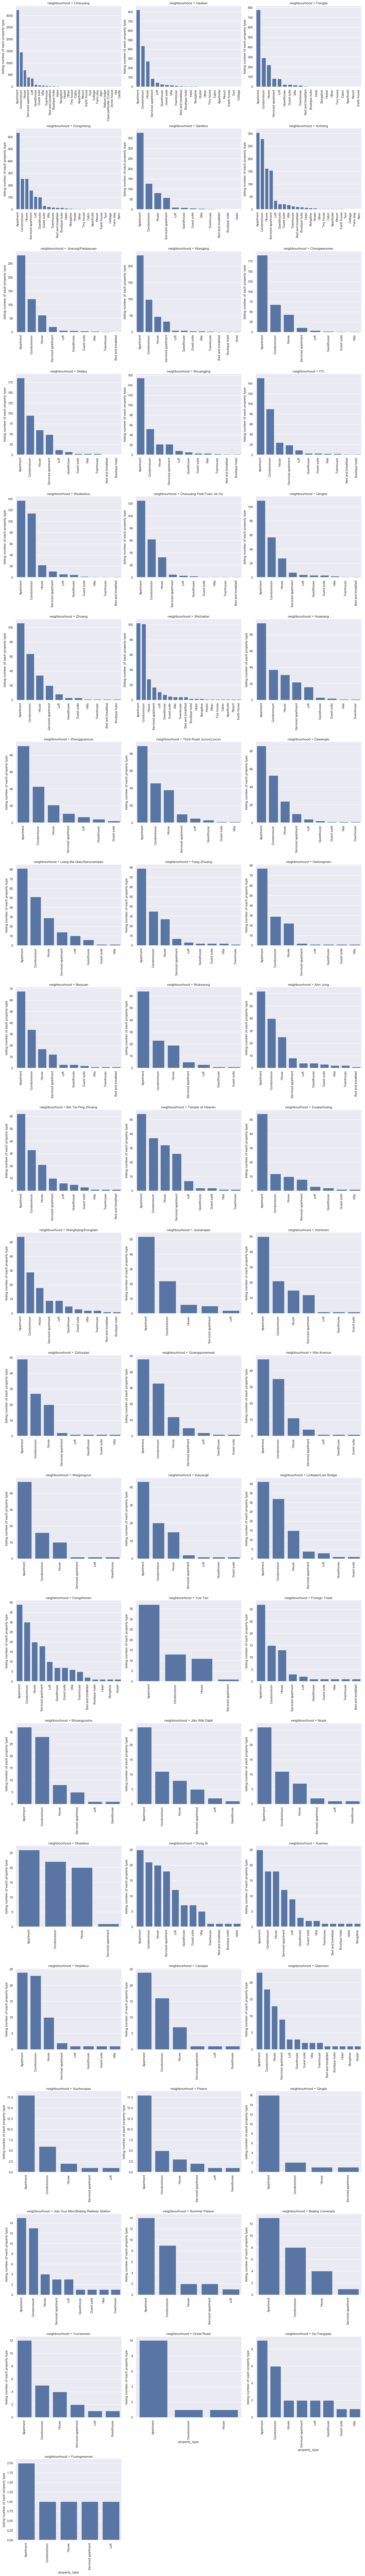

In [335]:
# visualize the number of differnt property type in different neighbourhood
plot = sns.FacetGrid(beijing_df, col='neighbourhood', sharex=False, sharey=False, col_wrap=3, size=6)
plot.map(sns.barplot, 'property_type', 'listing_counts_by_type')
plot.set_xticklabels(rotation=90)
plot.fig.tight_layout()
for ax in plot.axes.flat:
    ax.set_ylabel('listing number of each property type')

## Prices
### Compute the minimum, maximum and average listing price in your city.

<font color='blue'>    
In this part, we first check the price format and clean/transfer it. Then find the min, max, avg.
</font>

In [35]:
# filter out Beijing
beijing_price = listings_sub.filter(f.col('city')=='Beijing')                         

In [36]:
# define a function to get the currency sign of a price
extract_currency = f.udf(lambda x : x[0])   

In [37]:
# check if there is only one type of currency sign -- $
beijing_price.withColumn('currency', extract_currency(f.col('price')))\
             .select('currency').distinct()\
             .show()

+--------+
|currency|
+--------+
|       $|
+--------+



In [38]:
from re import sub
from decimal import Decimal

# define a function to clean the price. only keep numbers and drop $ and . ,
extract_price = f.udf(lambda price : Decimal(sub(r'[^\d.]', '', price)))

In [39]:
# apply the function on column price and make a new column
beijing_price = beijing_price.withColumn('price', extract_price(f.col('price')).cast(DoubleType()))

In [40]:
# sort the price
beijing_price.orderBy(f.desc('price')).show()

+----------+-------+--------------------+------------------+-------+--------------------+
|listing_id|   city|       neighbourhood|     property_type|  price|review_scores_rating|
+----------+-------+--------------------+------------------+-------+--------------------+
|  15666822|Beijing|                null|             House|71597.0|                null|
|  12689987|Beijing|            Chaoyang|         Apartment|71110.0|                 100|
|  28134193|Beijing|             Haidian|         Apartment|68984.0|                  60|
|  22382855|Beijing|            Chaoyang|       Condominium|68980.0|                 100|
|  35658816|Beijing|            Chaoyang|         Apartment|68088.0|                null|
|  34071825|Beijing|            Chaoyang|             House|68002.0|                null|
|  27587044|Beijing|                null|       Condominium|66665.0|                null|
|  28803519|Beijing|           Dongcheng|       Condominium|65973.0|                  80|
|  1548881

In [41]:
beijing_price.count()

32338

In [42]:

beijing_price.filter(f.col('neighbourhood').isNull()).count()

11416

<font color='blue'>    
According to above counts, 1/3 of the `neighbourhood` entries are null. So we decide to drop them.
</font>

In [45]:
# drop null value
beijing_price = beijing_price.filter(f.col('neighbourhood').isNotNull())
beijing_price.orderBy(f.desc('price')).show()

+----------+-------+--------------------+------------------+-------+--------------------+
|listing_id|   city|       neighbourhood|     property_type|  price|review_scores_rating|
+----------+-------+--------------------+------------------+-------+--------------------+
|  12689987|Beijing|            Chaoyang|         Apartment|71110.0|                 100|
|  28134193|Beijing|             Haidian|         Apartment|68984.0|                  60|
|  22382855|Beijing|            Chaoyang|       Condominium|68980.0|                 100|
|  35658816|Beijing|            Chaoyang|         Apartment|68088.0|                null|
|  34071825|Beijing|            Chaoyang|             House|68002.0|                null|
|  28803519|Beijing|           Dongcheng|       Condominium|65973.0|                  80|
|  15488817|Beijing|              Zhuang|Serviced apartment|63345.0|                  86|
|  20748712|Beijing|            Chaoyang|       Condominium|60002.0|                  60|
|  2194231

<font color='blue'>    
The most expensive listings in beijing is $711,110. It locates in `Chaoyang` district and it is an `Apartment`.
</font>

In [46]:
# calculate the min, max and average
beijing_price.select(f.min('price'), f.max('price'), f.avg('price')).show()

+----------+----------+-----------------+
|min(price)|max(price)|       avg(price)|
+----------+----------+-----------------+
|       0.0|   71110.0|565.5259535417264|
+----------+----------+-----------------+



### Compute and visualize the distribution of listing prices in your city.

<font color='blue'>    
A good way to show the distribution of listing prices is the histogram.</font>

In [47]:
beijing_price_df = beijing_price.toPandas()

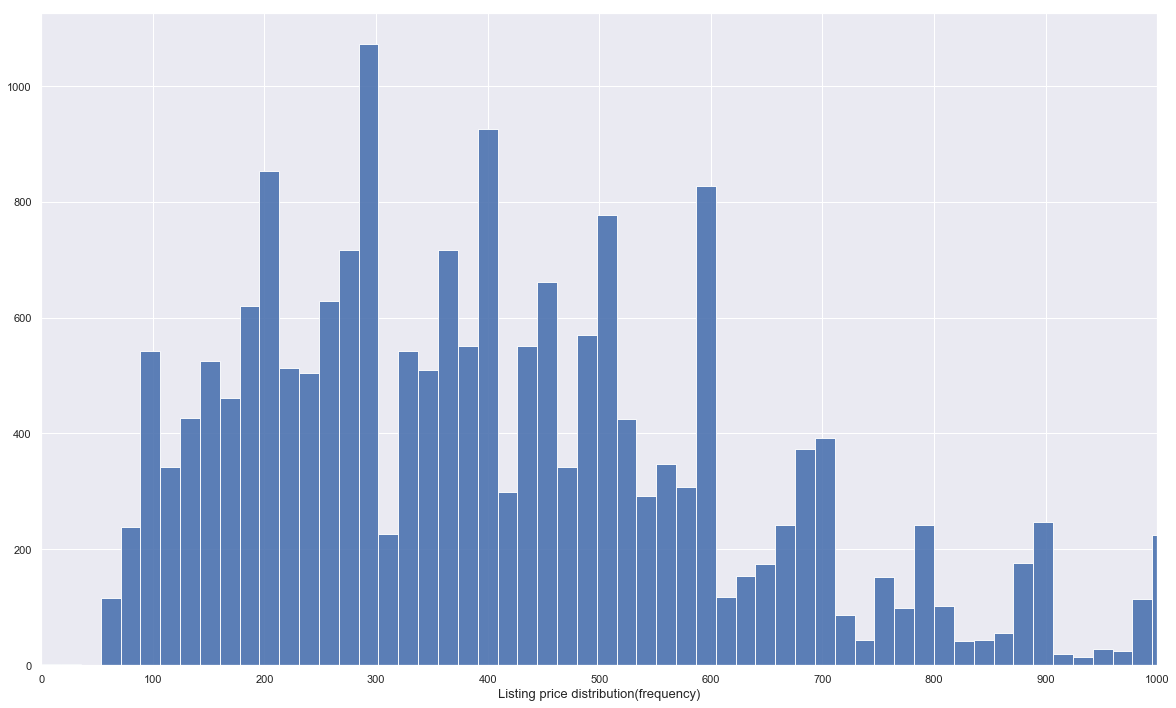

In [106]:
# histogram show the price distribution
plt.figure(figsize = [20,12])
plot = sns.distplot(beijing_price_df.price, kde=False, bins = 4000, hist_kws = {'alpha': 0.9}, color = sns.color_palette()[0])
plt.xticks(np.arange(0, beijing_price_df.price.max(), 100))
plt.xlim(0, 1000)
plt.xlabel('Listing price distribution(frequency)', fontsize=13)
plt.show()

The value of a listing is its rating divided by its price.

### Compute and show a dataframe with the 3 highest valued listings in each neighbourhood.

We compute the 3 highest valued listings in each neighbourhood in 4 steps :
1. <font color='blue'> cast the review ratings into integers in order to caculate the `value`. </font>


2. <font color='blue'> sort the `value` in descending way.</font>

3. <font color='blue'>  make a window filter to rank the value in each neigbourhood. </font>

4. <font color='blue'>  slect lisitings with rank number less than 3 in each neighbourhood. </font>



In [107]:
# cast string to integer
beijing_price = beijing_price.withColumn('review_scores_rating', (f.col('review_scores_rating')).cast(IntegerType()))

In [108]:
# calculate value
beijing_listing_value = beijing_price.withColumn('value', (f.col('review_scores_rating')/f.col('price')).alias('value'))

In [109]:
beijing_listing_value.show()

+----------+-------+--------------------+------------------+-----+--------------------+-------------------+
|listing_id|   city|       neighbourhood|     property_type|price|review_scores_rating|              value|
+----------+-------+--------------------+------------------+-----+--------------------+-------------------+
|   6317579|Beijing|           Dongcheng| Bed and breakfast|220.0|                  99|               0.45|
|   6622351|Beijing|           Dongcheng|        Guesthouse|555.0|                  95|0.17117117117117117|
|  12597460|Beijing|             Haidian|         Apartment|525.0|                  97|0.18476190476190477|
|  13495703|Beijing|            Chaoyang|             House|164.0|                 100| 0.6097560975609756|
|  13564871|Beijing|Liang Ma Qiao/San...|    Boutique hotel|640.0|                null|               null|
|  14473988|Beijing|          Shuangjing|         Apartment|525.0|                  94|0.17904761904761904|
|  14997784|Beijing|        

In [110]:
# build a window
sorted_by_value = Window.partitionBy('neighbourhood').orderBy(f.desc('value'))

# rank with window and filter by rank number
beijing_ranked_neigh = beijing_listing_value.withColumn('value_rank', f.rank().over(sorted_by_value))
beijing_ranked_neigh.filter(f.col('value_rank') <= 3).drop('value_rank').orderBy('neighbourhood', f.desc('value')).show()

+----------+-------+-------------------+-------------+-----+--------------------+------------------+
|listing_id|   city|      neighbourhood|property_type|price|review_scores_rating|             value|
+----------+-------+-------------------+-------------+-----+--------------------+------------------+
|  20195162|Beijing|           Ahn Jung|    Apartment| 85.0|                 100|1.1764705882352942|
|  16695169|Beijing|           Ahn Jung|    Apartment| 85.0|                  95|1.1176470588235294|
|  17971300|Beijing|           Ahn Jung|        House| 92.0|                  89| 0.967391304347826|
|  23209150|Beijing|Bei Tai Ping Zhuang|    Apartment| 85.0|                 100|1.1764705882352942|
|  15697701|Beijing|Bei Tai Ping Zhuang|    Apartment| 85.0|                  99|1.1647058823529413|
|  16318798|Beijing|Bei Tai Ping Zhuang|    Apartment| 92.0|                 100|1.0869565217391304|
|  33866823|Beijing|Bei Tai Ping Zhuang|       Hostel| 92.0|                 100|1.08695652

## Trends
Now we want to analyze the "popularity" of your city. The data does not contain the number of bookings per listing, but we have a large number of reviews, and we will assume that this is a good indicator of activity on listings.

### Compute and visualize the popularity(i.e. number of reviews) of your city over time.

In [111]:
# check the data type
reviews.printSchema()

root
 |-- listing_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- reviewer_id: string (nullable = true)
 |-- reviewer_name: string (nullable = true)
 |-- comments: string (nullable = true)



In [112]:
# join reviews with beijing's listings data
beijing_popularity = listings_sub.filter(f.col('city') == 'Beijing')\
                                 .join(reviews, ['listing_id'], 'inner')\
                                 .withColumn('date', f.col('date').cast(DateType()))

Compute and visualize the popularity (i.e., number of reviews) of your city over time.

In [113]:
# groupby day
beijing_popularity_by_city = beijing_popularity.groupBy('date')\
                                               .agg(f.count('id').alias('review_counts'))\
                                               .orderBy('date')\
                                               .toPandas()

In [114]:
beijing_popularity_by_city.head()

,date,review_counts
0,2010-08-25,1
1,2010-10-13,1
2,2011-06-02,1
3,2011-06-05,1
4,2011-08-02,1


In [123]:
# visulize the number of review_counts by time
dates = np.array(beijing_popularity_by_city['date'], dtype=np.datetime64)
source = ColumnDataSource(data=dict(date=dates, close=beijing_popularity_by_city['review_counts']))

p = figure(plot_height=300, plot_width=800, tools="xpan", toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           background_fill_color="#efefef", x_range=(dates[2000], dates[2284]))

p.line('date', 'close', source=source, legend_label='Beijing popularity over time')
p.yaxis.axis_label = 'Number of reviews'

select = figure(title="Drag the middle and edges of the selection box to change the range above",
                plot_height=130, plot_width=800, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line('date', 'close', source=source)
select.ygrid.grid_line_color = None
select.add_tools(range_tool)
select.toolbar.active_multi = range_tool

output_notebook()
show(column(p, select))

Loading BokehJS ...

### Compute and visualize the popularity of neighbourhoods over time.

If there are many neighbourhoods in your city, you should select a few interesting ones for comparison.

<font color='blue'> We select Chaoyang, Haidian, Fengtai, Dongchen based on the number of listings</font>

In [328]:
beijing_popularity_by_neigh = beijing_popularity.filter((f.col('neighbourhood')=='Chaoyang') | (f.col('neighbourhood')=='Haidian') | (f.col('neighbourhood')=='Fengtai') | (f.col('neighbourhood')=='Dongcheng'))\
                                                .groupBy('neighbourhood', 'date')\
                                                .agg(f.count('id').alias('review_counts'))\
                                                .orderBy('date')\
                                                .toPandas()

In [120]:
beijing_popularity_by_neigh.head()

,neighbourhood,date,review_counts
0,Chaoyang,2010-08-25,1
1,Chaoyang,2010-10-13,1
2,Dongcheng,2011-06-02,1
3,Dongcheng,2011-06-05,1
4,Dongcheng,2011-08-02,1


In [127]:
# visualize the popularity of neighbourhoods over time
source1 = beijing_popularity_by_neigh[beijing_popularity_by_neigh['neighbourhood']=='Chaoyang']
source2 = beijing_popularity_by_neigh[beijing_popularity_by_neigh['neighbourhood']=='Haidian']
source3 = beijing_popularity_by_neigh[beijing_popularity_by_neigh['neighbourhood']=='Fengtai']
source4 = beijing_popularity_by_neigh[beijing_popularity_by_neigh['neighbourhood']=='Dongcheng']

p = figure(plot_height=300, plot_width=800, tools="xpan", toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           background_fill_color="#efefef", x_range=(dates[2000], dates[2284]))

p.line(source1['date'], source1['review_counts'], legend_label='Chaoyang popularity over time', line_color='blue')
p.line(source2['date'], source2['review_counts'], legend_label='Haidian popularity over time', line_color='orange')
p.line(source3['date'], source3['review_counts'], legend_label='Fengtai popularity over time', line_color='red')
p.line(source4['date'], source4['review_counts'], legend_label='Dongcheng popularity over time', line_color='green')

p.yaxis.axis_label = 'Number of reviews'

select = figure(title="Drag the middle and edges of the selection box to change the range above",
                plot_height=130, plot_width=800, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line(source1['date'], source1['review_counts'])
select.line(source2['date'], source2['review_counts'])
select.line(source3['date'], source3['review_counts'])
select.line(source4['date'], source4['review_counts'])

select.ygrid.grid_line_color = None
select.add_tools(range_tool)
select.toolbar.active_multi = range_tool

output_notebook()
show(column(p, select))

Loading BokehJS ...

### Compute and visualize the popularity of your city by season. 
For example, visualize the popularity of your city per month.

In [314]:
# manipulate data into the format "MM-01-yyyy"
beijing_popularity_by_city_seasonal = beijing_popularity.withColumn('month', f.date_format(f.col('date'), 'MM-01-yyyy'))\
                                                        .groupBy('month')\
                                                        .agg(f.count('id').alias('review_counts'))\
                                                        .orderBy(f.col('month'))\
                                                        .toPandas()

In [315]:
beijing_popularity_by_city_seasonal.head()

,month,review_counts
0,01-01-2012,3
1,01-01-2013,7
2,01-01-2014,23
3,01-01-2015,42
4,01-01-2016,311


In [316]:
# Turn month column into datetime to fix the formatting issues and make processing easier
beijing_popularity_by_city_seasonal.month = pd.to_datetime(beijing_popularity_by_city_seasonal.month)

In [317]:
beijing_popularity_by_city_seasonal['Month_Name'] = beijing_popularity_by_city_seasonal.month.apply(lambda row: row.month_name())

In [318]:
beijing_popularity_by_city_seasonal['Year'] = beijing_popularity_by_city_seasonal.month.apply(lambda row: str(row.year))

In [319]:
beijing_popularity_by_city_seasonal = beijing_popularity_by_city_seasonal.set_index(['Month_Name', 'Year'])['review_counts'].unstack().loc[:, ['2012', '2013', '2014', '2015', '2016', '2017', '2018']].astype(int).reset_index()

In [320]:
beijing_popularity_by_city_seasonal

Year,Month_Name,2012,2013,2014,2015,2016,2017,2018
0,April,6,23,33,112,491,2002,4897
1,August,15,24,47,248,1268,3782,8603
2,December,10,23,70,258,1338,3000,7774
3,February,4,7,22,38,248,1180,2874
4,January,3,7,23,42,311,1311,3625
5,July,11,22,46,208,900,3090,7126
6,June,15,29,36,181,682,2397,5819
7,March,11,25,26,64,324,1452,1495
8,May,12,26,36,118,658,2391,5512
9,November,12,29,47,218,892,2521,6616


In [321]:
#visualize the popularity of your city by season
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
years = ['2012', '2013', '2014', '2015', '2016', '2017', '2018']
colors = sns.color_palette().as_hex()[2:len(years)+2]

p = figure(x_range = months, plot_height=250, plot_width = 1000, title="Fruit Counts by Year",
           toolbar_location=None, tools="")

p.vbar_stack(years, x='Month_Name', width=0.9, color=colors, source=beijing_popularity_by_city_seasonal, legend_label=years)

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"

output_notebook()
show(column(p))

Loading BokehJS ...

<font color='blue'> As the Airbnd is not so popular in Beijing before 2016, it is popularity is not shown obviously in above figure.  </font>

## Reviews
In this part you should determine which words used in reviews that are the most positive. 

The individual reviews do not have a rating of the listing, so we will assume that each review gave the average rating to the listing, i.e., the one on the listing.

You should assign a positivity weight to each word seen in reviews and list the words with the highest weight. It is up to you to decide what the weight should be. For example, it can be a function of the rating on the listing on which it occurs, the number of reviews it occurs in, and the number of unique listings for which it was used to review.

Depending on your choice of weight function, you may also want to do some filtering of words. For example, remove words that only occur in a few reviews.

<font color='blue'> We solve this question in steps:</font>


1. <font color='blue'>join the reviews into the listings data based on the listing's id.</font>
2. <font color='blue'>split the review comments into words and `explode` it into rows. Assume the word score euqals to the review score.</font>
3. <font color='blue'>groupy by distinct word and calculate the mean of word score as well as the word frequecy.</font>
4. <font color='blue'>calculate the weighted score of each word based on the formula below.</font>

$$
weighted\_score = average\_score * \sqrt{word\_frequency}
$$
5. <font color='blue'> show 5 words with the highest weighted score.</font>
6. <font color='blue'> show 5 words with the highest average score but drop the word whose frequency are less than 200 million.</font>
7. <font color='blue'> compare the words list.</font>

In [338]:
# data clean
rated_reviews = listings_sub.join(reviews, ['listing_id'], 'inner')\
                            .withColumn('date', f.col('date').cast(DateType()))\
                            .withColumn('review_scores_rating', (f.col('review_scores_rating')).cast(IntegerType()))\
                            .filter(f.col('review_scores_rating').isNotNull())\
                            .orderBy(f.desc('review_scores_rating'))

In [339]:
# calculate weighted score, average score and frequency
weighted_rated_reviews = rated_reviews.withColumn('words', explode(split(f.col('comments'), '\W+').alias('words')))\
                                      .select('words', 'review_scores_rating')\
                                      .groupBy('words')\
                                      .agg(f.mean('review_scores_rating').alias('avg_scores'), f.count('review_scores_rating').alias('frequency'))\
                                      .withColumn('weighted_scores', f.col('avg_scores')*f.col('frequency')**(1/2))\
                                      .orderBy(f.desc('weighted_scores'))\

In [340]:
weighted_rated_reviews.show(100)

+-----------+-----------------+---------+------------------+
|      words|       avg_scores|frequency|   weighted_scores|
+-----------+-----------------+---------+------------------+
|        and|95.38446260851613| 56651028| 717929.0631763524|
|        the|94.78737839063318| 45500093| 639376.4765151071|
|          a| 94.9671802056149| 37460320| 581245.0728823153|
|         to| 95.1163928305043| 35362264| 565620.8406016177|
|           |94.81618909027294| 29747527| 517139.7600633213|
|        was|94.98309220656003| 26994652|493497.74286926084|
|         is|95.02753095496094| 24109625| 466599.9340859086|
|         in|94.91229512144986| 22275819|  447960.082154477|
|        The|94.94596874803665| 15598380|374987.05716002936|
|       very| 95.1088069819577| 15197113|370767.17711119284|
|         of|95.12319003040311| 14630080| 363839.4250530417|
|        for|94.99795637736182| 14382303| 360270.3153953516|
|          s| 94.9018364609585| 13925262| 354141.0773476358|
|          I|95.12058574

<font color='blue'>In the above table, we can find some words has very weighted score. but they do not show positive or negative emotion in real life. So we will ignore them and concentrate on the `adjactives`. Then, we list the most 5 postive adjactives as below.
</font>
1. great
2. clean
3. nice
4. recommend
5. comfortable

In [344]:
weighted_rated_reviews.orderBy(f.desc('avg_scores')).filter(f.col('frequency') > 2000000).show(100)

+-----------+-----------------+---------+------------------+
|      words|       avg_scores|frequency|   weighted_scores|
+-----------+-----------------+---------+------------------+
|       home|96.47683896861794|  3004551|167229.48627856103|
|  beautiful|96.39824455807377|  2133252|140795.96412913894|
|     lovely|95.96121838963714|  2225101|143143.16576973384|
| definitely|95.83080206157007|  2772256|159559.17754859792|
|       back| 95.8136207053185|  2036385|136727.91674854665|
|      again|95.76117241289091|  3745677|185333.79413434947|
|comfortable|95.72393772561357|  3966960|  190655.556193693|
|      house|95.71923325060698|  3338718|174899.70636633915|
|    perfect| 95.7042850242088|  3475803| 178426.3371079245|
|       here|95.69576425772148|  2581531|153755.75759276975|
|      space| 95.6577555584908|  2256098|143680.94210296762|
|  recommend|95.64356330749465|  4672322|206738.86633391897|
|      quiet|95.62769643965468|  2215375|142333.56248263494|
|      super| 95.6033348

<font color='blue'>Then, we sort the average score and drop the words whose frequencies are less than 2 million, the most positive adjactives could be as below:</font>
1. beautiful
2. lovely
3. comfortable
4. perfect
5. recommend